In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import *

import AssembleData

## Loading Data

This function assemble and writes to a CSV

In [2]:
# Build Dataframe 
# MAL_df, all_genre  = AssembleData.read_files_all(write_csv=True, verbose=True)
# MAL_df = MAL_df.drop_duplicates('id')

If the pickle file exists, just load that instead to save time.

In [3]:
import pickle

# MAL_df = MAL_df.drop_duplicates('id')
# with open('1998_2015_data.pkl', 'w') as f:
#     pickle.dump(MAL_df, f)
#     pickle.dump(all_genre, f)

with open('1998_2015_data.pkl', 'r') as f:
    MAL_df = pickle.load(f)
    all_genre = pickle.load(f)

## Adding new fields and cleaning

In [4]:
MAL_df.drop_duplicates('id', inplace=True)

In [5]:
MAL_df['length'] = MAL_df['duration'] * MAL_df['episodes']
MAL_df['studios'] = MAL_df['studios'].apply(lambda s: eval(s))
MAL_df['aired_start'] = pd.to_datetime(MAL_df['aired_start'])
MAL_df['norm_length'] = (MAL_df['length'] - np.mean(MAL_df['length'])) / np.std(MAL_df['length'])

In [6]:
def fix_studios(l):
    """
        Fixes some the studio names in list l
    """
    # Collapse AIC companies under AIC
    # Collapse Xebec Zwei into Xebec
    for i in xrange(len(l)):
        if l[i].startswith('AIC'):
            l[i] = u'AIC'
        elif l[i].startswith('Xebec'):
            l[i] = u'Xebec'
    return l
            
MAL_df['studios'] = MAL_df['studios'].apply(fix_studios)

In [7]:
MAL_df['norm_score'] = (MAL_df['score'] - 1.0) / 9.0
MAL_df['bayes_score'] = (MAL_df['norm_score']*MAL_df['score_users'] + 1.0) / (MAL_df['score_users'] + 2.0)

In [8]:
MAL_df.reset_index(drop=True, inplace=True)

In [9]:
def split_field(df, field, new_field_name=None):
    new_rows = []
    for index, row in df.iterrows():
        for item in row[field]:
            new_rows.append((row['id'], item))
            
    needs_replace = False
    if new_field_name is None or len(new_field_name) == 0:
        new_field_name = "__temp_" + field
        needs_replace = True
        
    right_df = pd.DataFrame(new_rows, columns=['id', new_field_name])
    new_df = pd.merge(df, right_df, how='left', left_on='id', right_on='id')
    if needs_replace:
        del new_df[field]
        new_df[field] = new_df[new_field_name]
        del new_df[new_field_name]
        
    return new_df

def build_studios_set(df):
    split = split_field(df[['id', 'studios']], 'studios')
    split.dropna(axis=0, subset=['studios'], inplace=True)
    return split['studios'].unique()

all_studios = build_studios_set(MAL_df)
print all_studios.shape[0]
all_studios[:5]

301


array([u'Sunrise', u'Madhouse', u'J.C.Staff', u'Tatsunoko Production',
       u'Gonzo'], dtype=object)

In [10]:
def build_source_set(df):
    data = df['source'].copy()
    data.dropna(axis=0, inplace=True)
    return data.unique()

all_sources = build_source_set(MAL_df)
print all_sources.shape[0]
all_sources

16


array([u'Original', u'Manga', u'Light novel', u'Unknown', u'Game',
       u'4-koma manga', u'Novel', u'Visual novel', u'Picture book',
       u'Radio', u'Book', u'Other', u'Web manga', u'Card game', u'Music',
       u'Digital manga'], dtype=object)

In [11]:
print len(all_genre)

44


## Examining Data

In [11]:
def only_genre(g):
    return MAL_df[MAL_df[g] == 1]

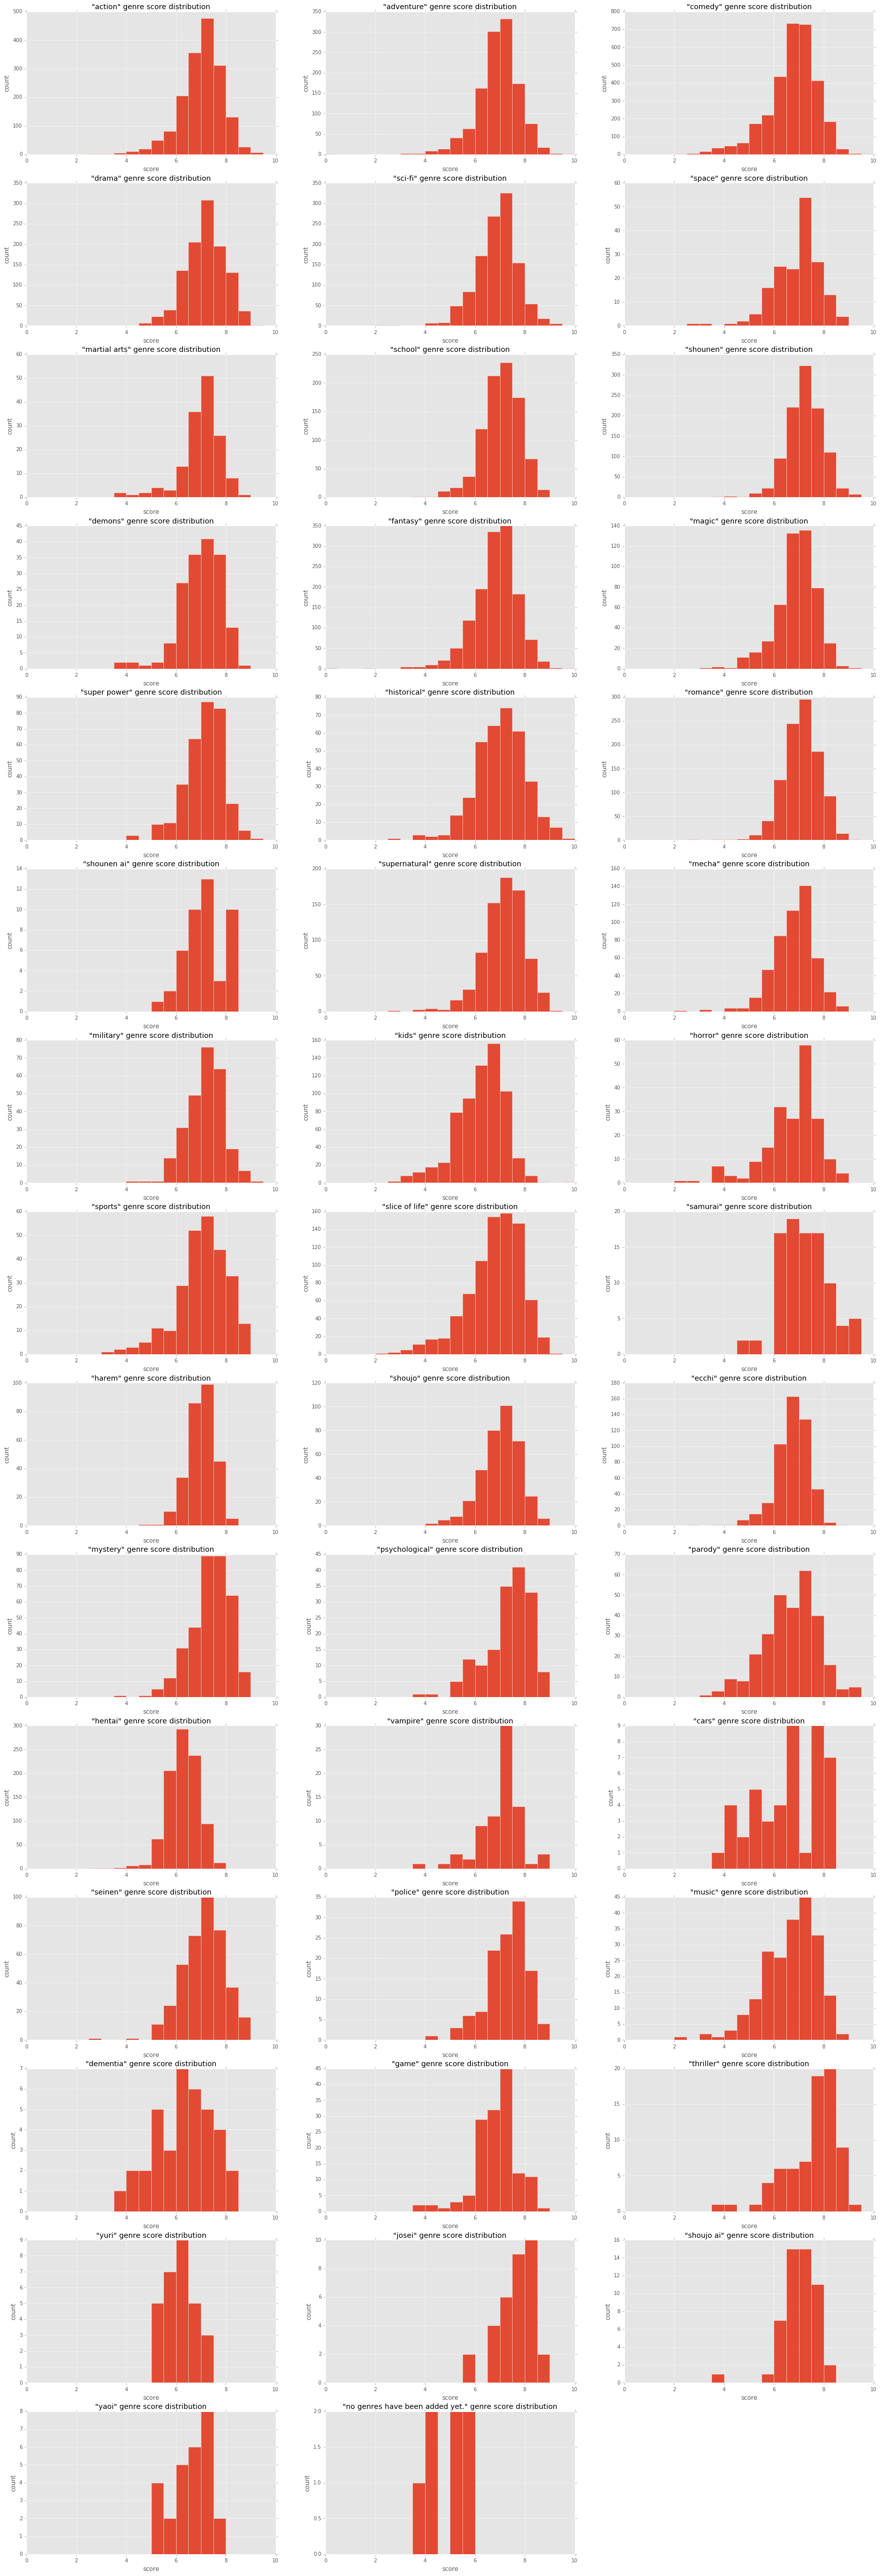

In [12]:
matplotlib.rcParams['figure.figsize'] = (30.0, 90.0)
plt.figure(1)
plt.gca().set_xscale("linear")

cols = 3
rows = np.ceil(len(all_genre) / float(cols))
i = 1
for g in all_genre:
    plt.subplot(rows, cols, i)
    genre_df = MAL_df[MAL_df[g] == 1]
    plt.hist(genre_df['score'], bins=20, range=[0.0,10.0])
    plt.xlabel("score")
    plt.ylabel("count")
    plt.title('"%s" genre score distribution' % g)
    i += 1

In [18]:
avg_genre_score_df = pd.DataFrame([(genre, MAL_df[MAL_df[genre] == 1]['bayes_score'].mean(), MAL_df[MAL_df[genre] == 1].shape[0]) for genre in all_genre],
                                  columns=['genre', 'bayes_score_mean', 'num_titles'])

In [19]:
avg_genre_score_df.sort_values('bayes_score_mean', ascending=False).head(10)

,genre,bayes_score_mean,num_titles
40,josei,0.735767,33
38,thriller,0.724777,75
27,mystery,0.707873,352
28,psychological,0.700698,161
34,police,0.697215,120
8,shounen,0.694178,1034
23,samurai,0.691172,93
18,military,0.685821,264
3,drama,0.684775,1083
16,supernatural,0.683603,753


In [20]:
avg_genre_score_df.sort_values('bayes_score_mean', ascending=True).head(10)

,genre,bayes_score_mean,num_titles
43,no genres have been added yet.,0.427311,7
39,yuri,0.574212,29
19,kids,0.575505,666
30,hentai,0.586310,923
36,dementia,0.592623,37
32,cars,0.615495,45
42,yaoi,0.618400,27
29,parody,0.625161,294
35,music,0.629005,214
20,horror,0.633208,196


In [6]:
matplotlib.rcParams['figure.figsize'] = (7.0, 5.0)
plt.figure(1)

def cross(g1, g2):
    return MAL_df[MAL_df.apply(lambda x: x[g1] == 1 and x[g2] == 1, axis=1)]

def cross_stat(g1, g2):
    genre_df = cross(g1,g2)
    print "%s x %s Count:" % (g1, g2), genre_df.shape[0]
    print "%s Mean:" % g1, MAL_df[MAL_df[g1] == 1]['score'].mean()
    print "%s Mean:" % g2, MAL_df[MAL_df[g2] == 1]['score'].mean()
    print "%s x %s Mean" % (g1, g2), genre_df['score'].mean()
    plt.hist(genre_df['score'], bins=20, range=[0.0,10.0])
    plt.xlabel("score")
    plt.ylabel("count")
    plt.title('"%s x %s" genre score distribution' % (g1,g2))

shounen x ecchi Count: 111
shounen Mean: 7.43436655405
ecchi Mean: 6.89067209776
shounen x ecchi Mean 7.1927027027


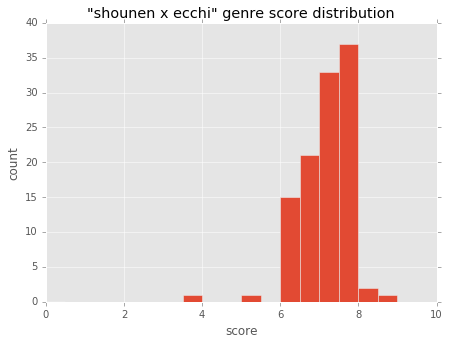

In [26]:
cross_stat("shounen", "ecchi")

shounen x harem Count: 49
shounen Mean: 7.43436655405
harem Mean: 7.08268199234
shounen x harem Mean 7.38551020408


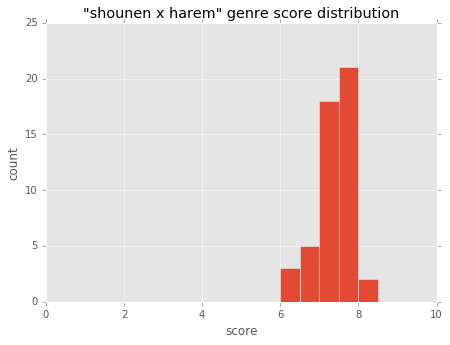

In [45]:
cross_stat("shounen", "harem")

slice of life x comedy Count: 471
slice of life Mean: 7.0903638814
comedy Mean: 7.03419582891
slice of life x comedy Mean 7.10925690021


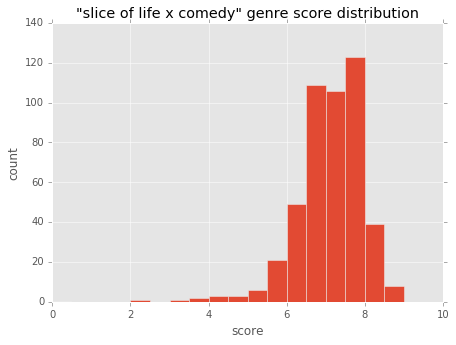

In [27]:
cross_stat("slice of life", "comedy")

slice of life x drama Count: 177
slice of life Mean: 7.0903638814
drama Mean: 7.36531015038
slice of life x drama Mean 7.37107344633


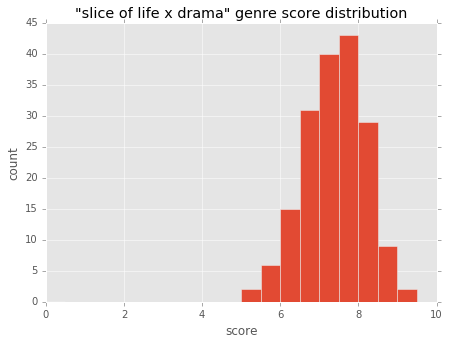

In [28]:
cross_stat("slice of life", "drama")

ecchi x harem Count: 140
ecchi Mean: 6.89067209776
harem Mean: 7.08268199234
ecchi x harem Mean 7.12864285714


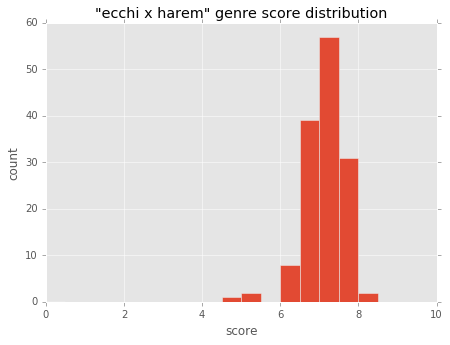

In [31]:
cross_stat("ecchi", "harem")

harem x shoujo Count: 27
harem Mean: 7.08268199234
shoujo Mean: 7.19387811634
harem x shoujo Mean 6.79777777778


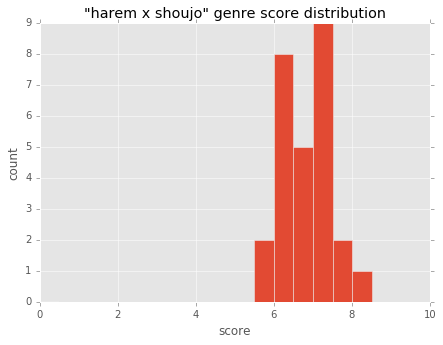

In [39]:
cross_stat("harem", "shoujo")

890
742
256
school x slice of life Count: 256
school Mean: 7.22405617978
slice of life Mean: 7.0903638814
school x slice of life Mean 7.326484375


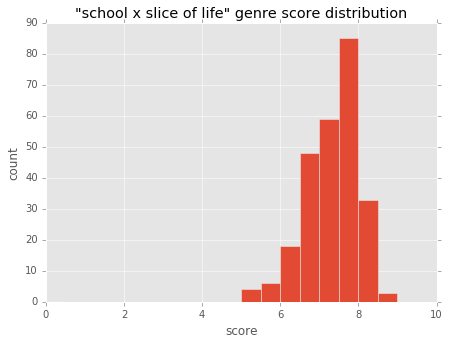

In [43]:
print only_genre("school").shape[0]
print only_genre("slice of life").shape[0]
print cross("school", "slice of life").shape[0]
cross_stat("school", "slice of life")

In [50]:
only_genre("vampire")

,action,adventure,aired_end,aired_start,broadcast,cars,category,comedy,dementia,demons,...,super power,supernatural,synopsis,thriller,title,type,url,vampire,yaoi,yuri
0,1,0,1998-09-23T00:00:00,1998-07-09T00:00:00,Unknown,0,anime,1,0,0,...,0,0,Shido Tatsuhiko is not only a private eye... h...,0,Night Walker: Mayonaka no Tantei,TV,https://myanimelist.net/anime/621/Night_Walker...,1,0,0
0,1,0,1998-03-30T00:00:00,1997-10-06T00:00:00,Unknown,0,anime,0,0,1,...,0,0,Evil Shinma (shape-shifting monsters and vampi...,0,Kyuuketsuhime Miyu (TV),TV,https://myanimelist.net/anime/690/Kyuuketsuhim...,1,0,0
0,1,1,2000-03-27T00:00:00,1999-10-18T00:00:00,Unknown,0,anime,0,0,0,...,0,0,This anime is based on a playstation game unde...,0,Wild Arms: Twilight Venom,TV,https://myanimelist.net/anime/347/Wild_Arms__T...,1,0,0
0,0,0,2001-06-01T00:00:00,1999-10-01T00:00:00,Unknown,0,anime,1,0,1,...,0,1,The first series is a set of 25 stories about ...,0,Gregory Horror Show,TV,https://myanimelist.net/anime/6069/Gregory_Hor...,1,0,0
0,0,0,2000-10-01T00:00:00,2000-04-01T00:00:00,Unknown,0,anime,1,0,1,...,0,1,"The second series, The Second Guest is similar...",0,Gregory Horror Show: The Second Guest,TV,https://myanimelist.net/anime/12481/Gregory_Ho...,1,0,0
0,0,0,2001-03-31T00:00:00,2000-10-07T00:00:00,Unknown,0,anime,1,0,1,...,0,1,"The third series, The Last Train is set with 2...",0,Gregory Horror Show: The Last Train,TV,https://myanimelist.net/anime/12483/Gregory_Ho...,1,0,0
0,0,0,2000-11-18T00:00:00,2000-11-18T00:00:00,None,0,anime,0,0,0,...,0,1,Teropterids are evil beasts which pose as huma...,0,Blood: The Last Vampire,Movie,https://myanimelist.net/anime/405/Blood__The_L...,1,0,0
0,1,0,2000-08-25T00:00:00,2000-08-25T00:00:00,None,0,anime,0,0,0,...,0,0,"The story revolves around D, the infamous ""dun...",0,Vampire Hunter D (2000),Movie,https://myanimelist.net/anime/543/Vampire_Hunt...,1,0,0
0,0,0,2000-12-18T00:00:00,2000-10-02T00:00:00,Unknown,0,anime,1,0,0,...,0,0,"Even after death, life is full of paperwork an...",0,Yami no Matsuei,TV,https://myanimelist.net/anime/553/Yami_no_Matsuei,1,0,0
0,0,1,2002-01-25T00:00:00,2000-05-25T00:00:00,None,0,anime,0,0,0,...,0,1,"Kujo Jotaro is a normal, popular Japanese high...",0,JoJo no Kimyou na Bouken: Adventure,OVA,https://myanimelist.net/anime/665/JoJo_no_Kimy...,1,0,0


## Analyzing Score and Popularity

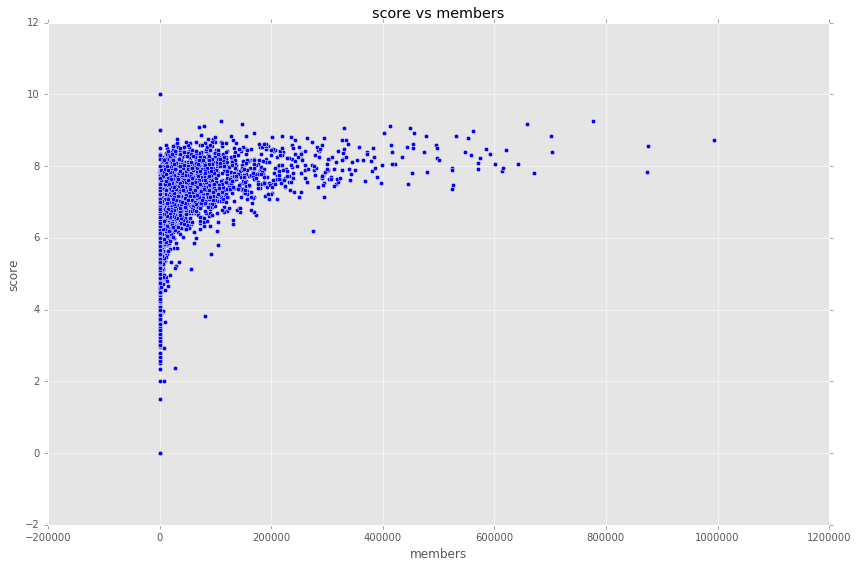

In [341]:
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['score'])
plt.xlabel("members")
plt.ylabel("score")
plt.title('score vs members')
plt.show()

Probably need to do normalization eventually.
**score_users** is the number of users that scored the anime.

Using Bayes scores instead (normalized to scale of 1.0, added rating of 0 and 1).

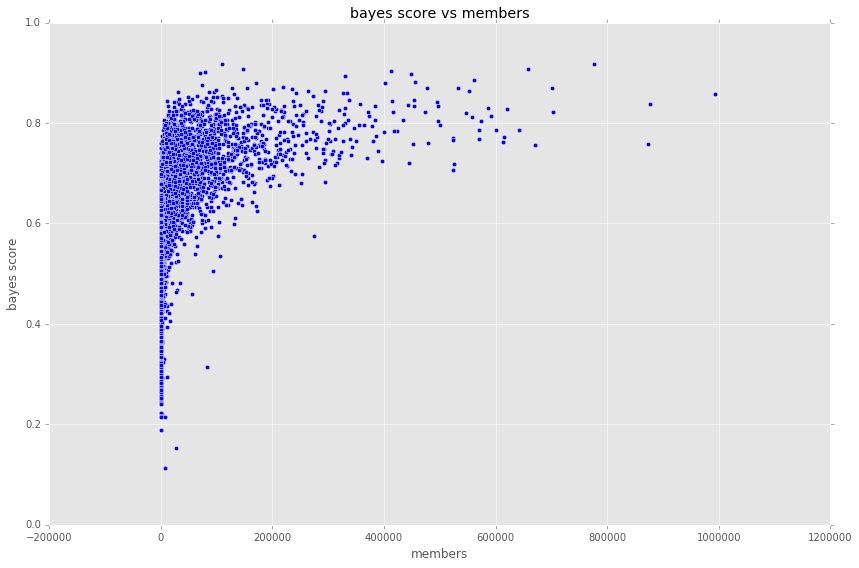

In [79]:
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['bayes_score'])
plt.xlabel("members")
plt.ylabel("bayes score")
plt.title('bayes score vs members')
plt.show()

### Identifying Outliers

In [87]:
MAL_df[MAL_df['score'] > 9.5][['title', 'members', 'url']]

,title,members,url
0,Kahei no Umi,41,https://myanimelist.net/anime/33607/Kahei_no_Umi
0,Shenmi Shijie Lixian Ji,36,https://myanimelist.net/anime/32796/Shenmi_Shi...
0,Fushigi no Yappo Shima: Pukipuki to Poi,24,https://myanimelist.net/anime/33842/Fushigi_no...
0,Nar Doma Special,62,https://myanimelist.net/anime/32275/Nar_Doma_S...


### Hipster

In [105]:
MAL_df[(MAL_df['score'] < 10) & (MAL_df['score'] > 8.8) & (MAL_df['members'] > 80000) & (MAL_df['members'] < 200000)][['title', 'score', 'members', 'url']]

,title,score,members,url
0,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,8.83,127358,https://myanimelist.net/anime/44/Rurouni_Kensh...
0,Hajime no Ippo,8.83,154337,https://myanimelist.net/anime/263/Hajime_no_Ippo
0,Gintama',9.16,147912,https://myanimelist.net/anime/9969/Gintama
0,Haikyuu!! Second Season,8.92,169748,https://myanimelist.net/anime/28891/Haikyuu_Se...
0,Gintama°,9.25,109987,https://myanimelist.net/anime/28977/Gintama%C2%B0


### "Hall of Fame"

In [103]:
MAL_df[MAL_df['members'] > 740000][['title', 'members', 'score', 'url']]

,title,members,score,url
0,Death Note,993983,8.72,https://myanimelist.net/anime/1535/Death_Note
0,Fullmetal Alchemist: Brotherhood,775983,9.26,https://myanimelist.net/anime/5114/Fullmetal_A...
0,Sword Art Online,873750,7.83,https://myanimelist.net/anime/11757/Sword_Art_...
0,Shingeki no Kyojin,875979,8.55,https://myanimelist.net/anime/16498/Shingeki_n...


### "Runner Ups"

In [104]:
MAL_df[(MAL_df['members'] > 640000) & (MAL_df['members'] < 740000)][['title', 'members', 'score', 'url']]

,title,members,score,url
0,Naruto,670909,7.81,https://myanimelist.net/anime/20/Naruto
0,Code Geass: Hangyaku no Lelouch,701138,8.83,https://myanimelist.net/anime/1575/Code_Geass_...
0,Angel Beats!,703140,8.40,https://myanimelist.net/anime/6547/Angel_Beats
0,Mirai Nikki (TV),642454,8.07,https://myanimelist.net/anime/10620/Mirai_Nikk...
0,Steins;Gate,657889,9.17,https://myanimelist.net/anime/9253/Steins_Gate


### Amazing.

In [97]:
MAL_df[(MAL_df['score'] < 6) & (MAL_df['score'] > 4) & (MAL_df['members'] > 32000)][['title', 'score', 'members', 'url']]

,title,score,members,url
0,Boku no Pico,5.14,56291,https://myanimelist.net/anime/1639/Boku_no_Pico
0,Diabolik Lovers,5.81,105478,https://myanimelist.net/anime/17513/Diabolik_L...
0,Glasslip,5.54,92919,https://myanimelist.net/anime/23079/Glasslip
0,Chaos Dragon: Sekiryuu Seneki,5.86,61242,https://myanimelist.net/anime/30091/Chaos_Drag...
0,Bikini Warriors,5.34,34180,https://myanimelist.net/anime/30782/Bikini_War...


In [94]:
MAL_df[(MAL_df['score'] < 6.5) & (MAL_df['members'] > 200000)][['title', 'members', 'url']]

,title,members,url
0,School Days,275182,https://myanimelist.net/anime/2476/School_Days


In [93]:
MAL_df[(MAL_df['score'] < 4) & (MAL_df['members'] > 50000)][['title', 'members', 'url']]

,title,members,url
0,Pupa,82224,https://myanimelist.net/anime/19315/Pupa


In [92]:
MAL_df[(MAL_df['score'] < 2.5) & (MAL_df['members'] > 3000)][['title', 'members', 'url']]

,title,members,url
0,Tenkuu Danzai Skelter+Heaven,7486,https://myanimelist.net/anime/3287/Tenkuu_Danz...
0,Mars of Destruction,27056,https://myanimelist.net/anime/413/Mars_of_Dest...


### Analyzing Scoring Users vs Score

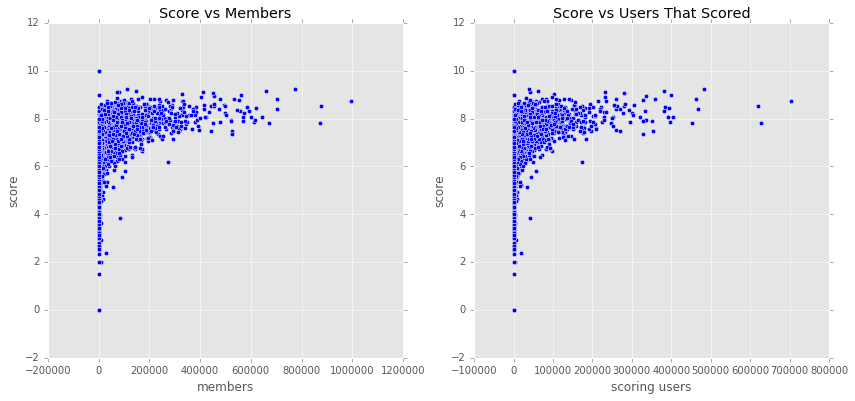

In [340]:
matplotlib.rcParams['figure.figsize'] = (14.0, 6.0)
plt.subplot(1, 2, 1)
plt.scatter(MAL_df['members'], MAL_df['score'])
plt.xlabel("members")
plt.ylabel("score")
plt.title('Score vs Members')

plt.subplot(1, 2, 2)
plt.scatter(MAL_df['score_users'], MAL_df['score'])
plt.xlabel("scoring users")
plt.ylabel("score")
plt.title('Score vs Users That Scored')
plt.show()

In [115]:
MAL_df[(MAL_df['score_users'] > 430000)][['title', 'members', 'score', 'url']]

,title,members,score,url
0,Naruto,670909,7.81,https://myanimelist.net/anime/20/Naruto
0,Death Note,993983,8.72,https://myanimelist.net/anime/1535/Death_Note
0,Code Geass: Hangyaku no Lelouch,701138,8.83,https://myanimelist.net/anime/1575/Code_Geass_...
0,Fullmetal Alchemist: Brotherhood,775983,9.26,https://myanimelist.net/anime/5114/Fullmetal_A...
0,Angel Beats!,703140,8.40,https://myanimelist.net/anime/6547/Angel_Beats
0,Sword Art Online,873750,7.83,https://myanimelist.net/anime/11757/Sword_Art_...
0,Shingeki no Kyojin,875979,8.55,https://myanimelist.net/anime/16498/Shingeki_n...


## Examining Impact of Studios

On MyAnimeList, the company that is primarily responsible for the animation and production of an anime is listed as the *studio*. Some animes have more than one studio responsible for it (e.g. *Uchuu Senkan Yamato 2199* has both Xebec and AIC listed as studios), but our web scrapping only picked up the first. In most cases, the first listed studio on MyAnimeList is the primary studio, and any subsequent ones are supporting studios.

In [126]:
studio_df = split_field(MAL_df, "studios")
print MAL_df.shape[0]
print studio_df.shape[0]

7048
7387


In [5]:
MAL_df = studio_df

In [52]:
MAL_df['studios']

0                          Sunrise
1                         Madhouse
2                        J.C.Staff
3             Tatsunoko Production
4                            Gonzo
5                 Nippon Animation
6                              OLM
7                              AIC
8                    Chaos Project
9                   Studio Pierrot
10                       J.C.Staff
11                     Studio Deen
12                         Ajia-Do
13           Tamura Shigeru Studio
14                     Studio Deen
15                  Hal Film Maker
16                           Eiken
17                        Madhouse
18                 Production Reed
19                             AIC
20               Shin-Ei Animation
21                     Studio Deen
22                         Sunrise
23             Tokyo Movie Shinsha
24                          Gainax
25                       J.C.Staff
26           Phoenix Entertainment
27                    Studio Junio
28                  

In [6]:
studios = MAL_df['studios'].unique()
by_studios = MAL_df.groupby('studios', as_index=False)

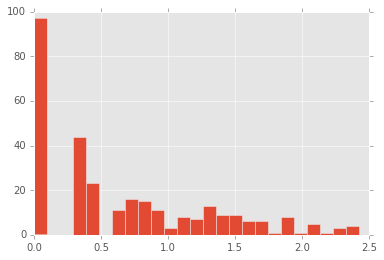

In [54]:
plt.hist(np.log10(by_studios.size()), bins=25);

When going through the data per producer, we noticed that some of the results we got were not aligned with our initial expectations.

This is because studios often produce small video animations to advertise their mainline series. There are many of these OVA's (original video animations) and ONA's (original net animations), and they typically score worse than their companion mainline series due to their inherent commercial nature. Upon realizing that these entries can disproportionately affect our mean, we decided to filter these short entries out. We did this by multiplying their duration by their epsidoe count, removing all entries that are less than 30 minutes long.

In [12]:
# Get only entries that have total length greater than 30 minutes
sig_length = MAL_df[MAL_df['length'] > 30]
print "Total entries:", len(MAL_df)
print "Significant:", len(sig_length)

Total entries: 7048
Significant: 4727


In [47]:
split = split_field(sig_length, 'studios')
# split = split_field(MAL_df, 'studios')
by_studios = split.groupby('studios', as_index=False)


bigger_studios = by_studios.filter(lambda data: len(data) > 2)
bigger_studios_groups = bigger_studios.groupby('studios', as_index=False)
bigger_studios_size = bigger_studios_groups.size().to_frame('num_titles')
bigger_studios_scores_members = bigger_studios_groups[['score','members']].agg(np.mean)
bigger_studios_members_sorted = bigger_studios.sort_values('members', ascending=False).groupby('studios')
bigger_studios_max = bigger_studios_members_sorted['members'].max().to_frame('max')
bigger_studios_2nd = bigger_studios_members_sorted.nth(1)['members'].to_frame('2nd')
bigger_studios_3rd = bigger_studios_members_sorted.nth(2)['members'].to_frame('3rd')
merged = pd.merge(bigger_studios_scores_members, bigger_studios_size, how='inner', right_index=True, left_on='studios')
merged = pd.merge(merged, bigger_studios_max, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_2nd, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_3rd, how='left', left_on='studios', right_index=True)
merged = merged.sort_values(['score', 'members'], ascending=False)
# merged = merged.sort_values(['3rd'], ascending=False)
merged = merged.reset_index(drop=True)
merged[['studios', 'score', 'members', 'num_titles']].head(20)
#merged[merged['studios'] == "8bit"]

#split[split['studios'] == "8bit"][['title', 'members']].sort_values('members', ascending=False)

#by_studios.get_group('CoMix Wave Films')['title']
# avg_scores = []
# avg_members = []
# print len(bigger_studios)
# for studio, data in :
#     print studio
#     print data.head()
#     break

,studios,score,members,num_titles
0,Studio Rikka,8.253333,83182.666667,3
1,Tokyo Movie Shinsha,8.062500,15385.500000,4
2,Khara,8.002500,130132.750000,4
3,Studio Ghibli,7.933077,109151.692308,13
4,White Fox,7.816154,186311.769231,13
5,Kyoto Animation,7.773571,159870.761905,42
6,Pastel,7.743333,24463.333333,3
7,Wit Studio,7.722308,141112.769231,13
8,MAPPA,7.690000,118043.625000,8
9,David Production,7.615455,88978.818182,11


In [52]:
merged = merged.sort_values(['2nd'], ascending=False)
merged = merged.reset_index(drop=True)
merged[['studios', 'score', 'members', 'num_titles', 'max', '2nd', '3rd']].head(20)

,studios,score,members,num_titles,max,2nd,3rd
0,Studio Pierrot,7.267065,63080.467391,92,670909,614635,600528
1,Bones,7.563714,112027.371429,70,775983,591758,570321
2,Madhouse,7.414865,75710.470270,185,993983,585893,531777
3,A-1 Pictures,7.552118,119640.882353,85,873750,573435,570568
4,Sunrise,7.309779,40413.292818,181,701138,561983,477128
5,P.A. Works,7.537778,154485.111111,18,703140,523222,299206
6,Production I.G,7.482739,61751.783439,157,875979,497546,452019
7,White Fox,7.816154,186311.769231,13,657889,478868,399507
8,Shaft,7.548824,73935.323529,68,473588,454499,339497
9,Kyoto Animation,7.773571,159870.761905,42,557765,449002,422665


## Learning By Studios

In [13]:
intuitive_thresholds = [
    ('barely_watchable', 6.7),
    ('average', 7.2),
    ('above_average', 7.6),
    ('recommendable', 8.0),
    ('amazing', 8.5),
    ('gods', 9.0)
]

def percentages(df):
    print "Using regular score"
    for label, val in intuitive_thresholds:
        print "{} ({}): {}".format(
            label,
            val,
            1. - float(sum(df['score'] > val)) / df.shape[0])
        
    print ""
    print "Using bayes scores"
    for label, val in intuitive_thresholds:
        thresh = ((val - 1.0) / 9.0)
        print "{} ({}): {}".format(
            label,
            thresh,
            1. - float(sum( df['bayes_score'] > thresh )) / df.shape[0])

print "==== Including all titles ===="
percentages(MAL_df)

print ""
print "==== Throw away less than 30 min ===="
percentages(sig_length)


==== Including all titles ====
Using regular score
barely_watchable (6.7): 0.47247446084
average (7.2): 0.694665153235
above_average (7.6): 0.851447219069
recommendable (8.0): 0.935726447219
amazing (8.5): 0.987514188422
gods (9.0): 0.998155505108

Using bayes scores
barely_watchable (0.633333333333): 0.483115777526
average (0.688888888889): 0.700340522134
above_average (0.733333333333): 0.854994324631
recommendable (0.777777777778): 0.937712826334
amazing (0.833333333333): 0.988365493757
gods (0.888888888889): 0.998723041998

==== Throw away less than 30 min ====
Using regular score
barely_watchable (6.7): 0.390945631479
average (7.2): 0.622170509837
above_average (7.6): 0.803257880262
recommendable (8.0): 0.911783372118
amazing (8.5): 0.982018193357
gods (9.0): 0.997461392003

Using bayes scores
barely_watchable (0.633333333333): 0.401523164798
average (0.688888888889): 0.628940131161
above_average (0.733333333333): 0.806431140258
recommendable (0.777777777778): 0.913264226782
amazin

In [14]:
def split_data_by_date(df):
    df = df.sort_values('aired_start')
    t_date = pd.to_datetime('2012-01-01')
    v_date = pd.to_datetime('2015-01-01')
    train = df[df['aired_start'] < t_date]
    val   = df[(df['aired_start'] >= t_date) & (df['aired_start'] < v_date)]
    test  = df[df['aired_start'] >= v_date]
    return train, val, test
    
train_df, val_df, test_df = split_data_by_date(MAL_df)
print "train", train_df.shape[0]
print "validation", val_df.shape[0]
print "test", test_df.shape[0]

train 4685
validation 1754
test 609


In [15]:
def make_studio_features(df, studio_names):
    new_df = df[['id', 'studios']].copy()
    for studio in studio_names:
        new_df[studio] = new_df['studios'].apply(lambda l: studio in l).astype(float)
    return new_df[studio_names]
    
studio_features = make_studio_features(val_df, all_studios)
print "Got {} feature examples from {} raw examples".format(studio_features.shape[0],  val_df.shape[0])

print val_df.head()[['title', 'studios']]
print studio_features.head()[['Sunrise', "Brain's Base", 'Seven', 'Shaft']]

Got 1754 feature examples from 1754 raw examples
                                  title           studios
4813                   Tales of Gekijou         [Sunrise]
4787  Guilty Crown Kiseki: Reassortment  [Production I.G]
5180    The Night Game: Neko no Sakusen                []
4726             Natsume Yuujinchou Shi    [Brain's Base]
4718               New Prince of Tennis  [Production I.G]
      Sunrise  Brain's Base  Seven  Shaft
4813      1.0           0.0    0.0    0.0
4787      0.0           0.0    0.0    0.0
5180      0.0           0.0    0.0    0.0
4726      0.0           1.0    0.0    0.0
4718      0.0           0.0    0.0    0.0


In [147]:
from sklearn import linear_model



X_tr, y_tr = make_studio_features(train_df, all_studios), train_df['score']
X_cv, y_cv = make_studio_features(val_df, all_studios), val_df['score']

print y_cv.shape[0]

clf = linear_model.LinearRegression()
clf.fit(X_tr, y_tr)

r = clf.score(X_cv, y_cv)
print "least squares on self: ", r

pair = zip(clf.coef_, X_tr.columns)
pair = sorted(pair)

for p in pair:
    print p[1], ": ", p[0]


1112
least squares on self:  0.228793101462
Studio Junio :  -7.33814200382e+12
REALTHING :  -204955668277.0
Beijing Huihuang Animation Company :  -131188943734.0
Project No.9 :  -10909498043.3
Studio March :  -7700256225.59
Idea Factory :  -4.57413818641
Kenji Studio :  -2.90624167536
Nexus :  -1.89353598302
GARDEN LODGE :  -1.65471579646
Marine Entertainment :  -1.47906547419
Romanov Films :  -1.27419211482
SOEISHINSHA :  -1.2703163824
Kachidoki Studio :  -1.19130121394
MooGoo :  -1.06292217812
Studio PuYUKAI :  -0.948232155231
Mook Animation :  -0.934745093333
Dongwoo A&E :  -0.892732323274
Genco :  -0.805927730476
Egg :  -0.796012183177
ACC Production :  -0.786855202106
Ishikawa Pro :  -0.751609107005
Studio Wombat :  -0.730116345949
Sugar Boy :  -0.71191718351
Natural High :  -0.647328834919
Public & Basic :  -0.56909265181
Pollyanna Graphics :  -0.565604468333
Asahi Production :  -0.537407961718
DLE :  -0.517071021739
LMD :  -0.4918412553
Amber Film Works :  -0.482170753881
GANSIS

In [339]:
from sklearn import linear_model

# def make_features(df):
#     p1 = make_studio_features(df, all_studios)
#     p2 = df[all_genre]
#     join = pd.merge(p1, p2, how='inner', left_index=True, right_index=True)
#     #join['length'] = df['length']
#     #join['score'] = df['score']
#     return join
#     #return p1

X_tr, y_tr = make_features(train_df), train_df['bayes_score']
X_cv, y_cv = make_features(val_df), val_df['bayes_score']

clf = linear_model.LinearRegression()
clf.fit(X_tr, y_tr)

r = clf.score(X_cv, y_cv)
print "least squares on self: ", r

# pair = zip(clf.coef_, X_tr.columns)
# pair = sorted(pair)

# for p in pair:
#     print p[1], ": ", p[0]


least squares on self:  -8.12880632878e+13


In [181]:
print train_df.shape

other = X_tr.copy()
other['title'] = train_df['title']
other

(4685, 72)


,Sunrise,Madhouse,J.C.Staff,Tatsunoko Production,Gonzo,Nippon Animation,OLM,AIC,Chaos Project,Studio Pierrot,...,music,dementia,game,thriller,yuri,josei,shoujo ai,yaoi,no genres have been added yet.,title
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Sazae-san
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Doraemon (1979)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Sore Ike! Anpanman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Narara Superboard
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Crayon Shin-chan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Nintama Rantarou
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Shima Shima Tora no Shimajirou
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Oyako Club
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Chibi Maruko-chan (1995)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,Azuki-chan


In [192]:
abp = MAL_df[MAL_df['title'] == 'Amagi Brilliant Park']
clf.predict(make_features(abp))

array([  1.38554841e+12])

## Analyzing Source influence

In [16]:
def make_source_features(df, source_names):
    new_df = df[['id', 'source']].copy()
    for source in source_names:
        new_df[source] = new_df['source'].apply(lambda s: s == source).astype(float)
    return new_df[source_names]


In [34]:
MAL_df.head()[['title', 'source']]

,title,source
0,Cowboy Bebop,Original
1,Sexy Commando Gaiden: Sugoiyo!! Masaru-san Spe...,Manga
2,Majutsushi Orphen,Light novel
3,Generator Gawl,Unknown
4,Psychic Force,Game


In [35]:
with_sources = pd.merge(MAL_df, make_source_features(MAL_df, all_sources), how='inner', left_index=True, right_index=True)
with_sources.head()[['title'] + list(all_sources)]

,title,Original,Manga,Light novel,Unknown,Game,4-koma manga,Novel,Visual novel,Picture book,Radio,Book,Other,Web manga,Card game,Music,Digital manga
0,Cowboy Bebop,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sexy Commando Gaiden: Sugoiyo!! Masaru-san Spe...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Majutsushi Orphen,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Generator Gawl,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Psychic Force,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


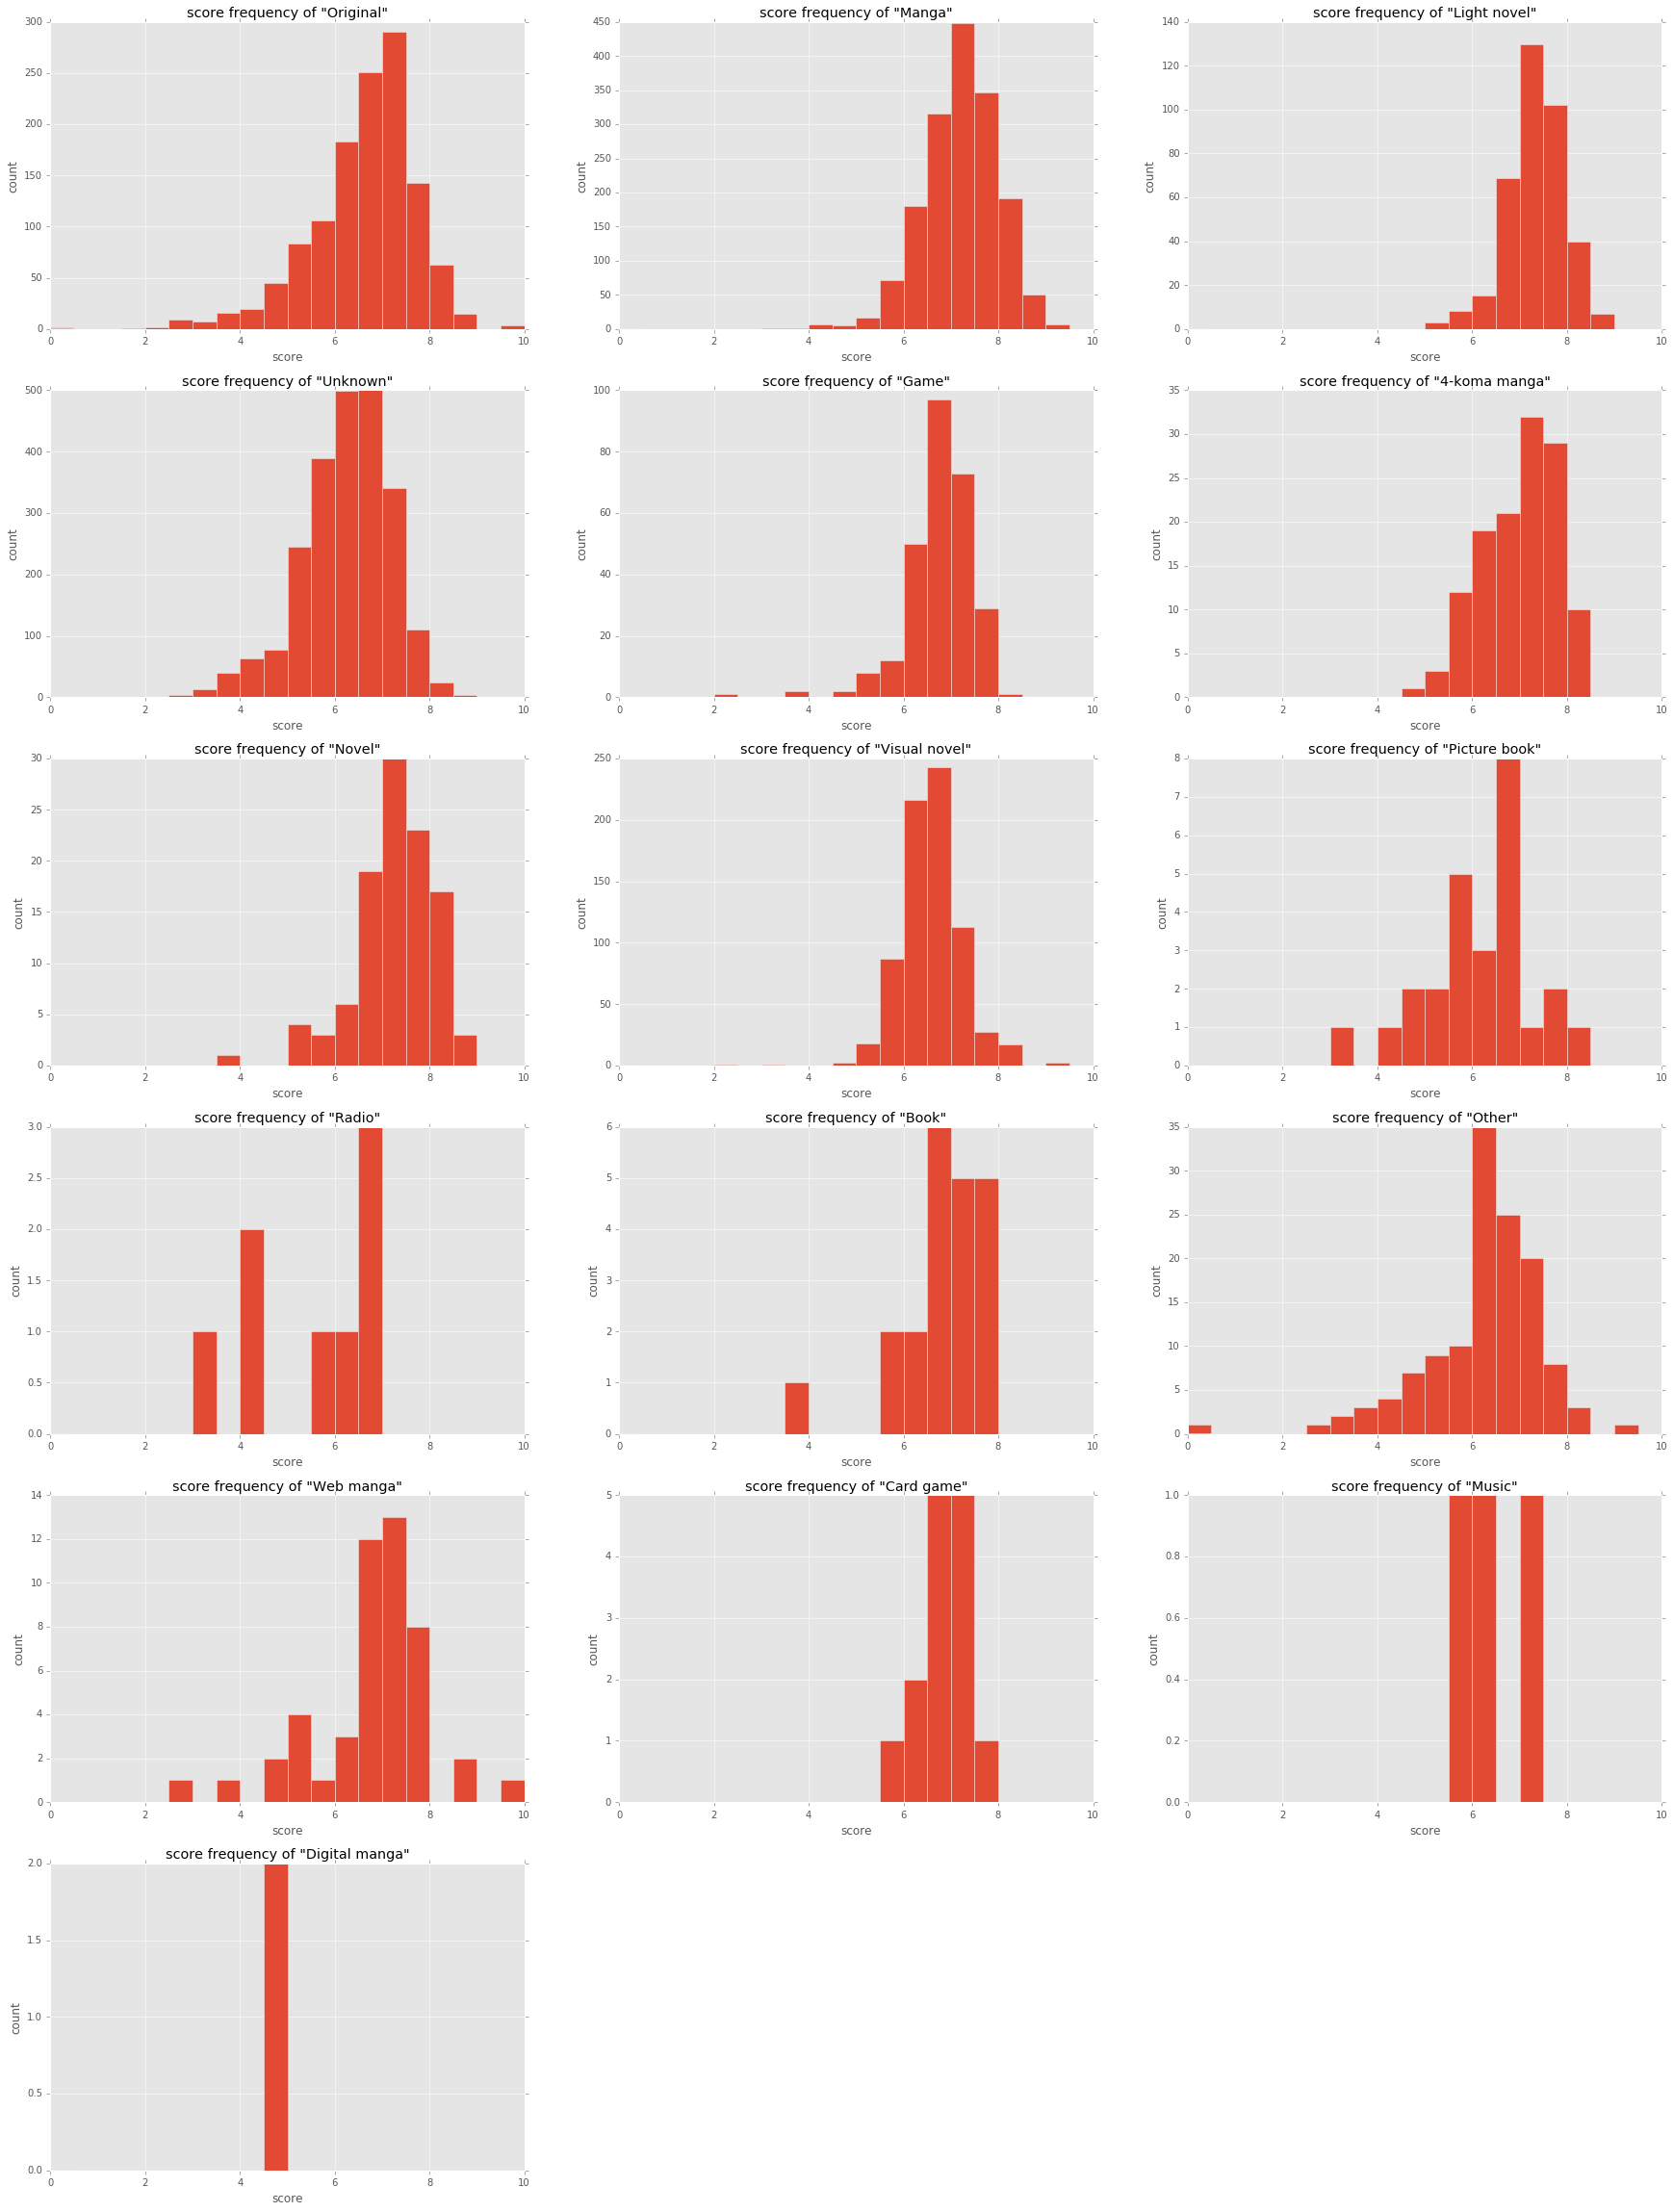

In [20]:
matplotlib.rcParams['figure.figsize'] = (30.0, 40.0)
i = 1
for source in all_sources:
    plt.subplot(6, 3, i)
    plt.hist(with_sources[with_sources[source] == 1.0]['score'], bins=20, range=[0.0,10.0])
    plt.xlabel('score')
    plt.ylabel('count')
    plt.title('score frequency of "%s"' % source)
    i += 1

In [42]:
median_score_sources = pd.DataFrame(
                        [(source,
                         with_sources[with_sources[source] == 1.0]['bayes_score'].median(),
                         with_sources[with_sources[source] == 1.0].shape[0])
                        for source in all_sources],
                        columns=['source', 'median_bayes_score', 'num_titles'])

In [44]:
median_score_sources.sort_values('num_titles', ascending=False).head(5)

,source,median_bayes_score,num_titles
3,Unknown,0.587979,2310
1,Manga,0.696220,1641
0,Original,0.639990,1237
7,Visual novel,0.618641,727
2,Light novel,0.707762,374


In [41]:
median_score_sources.sort_values('median_bayes_score', ascending=False)

,source,median_bayes_score,num_titles
2,Light novel,0.704492,374
6,Novel,0.694138,106
1,Manga,0.689920,1641
5,4-koma manga,0.668799,127
13,Card game,0.651807,14
4,Game,0.639419,275
10,Book,0.639293,21
12,Web manga,0.634543,48
0,Original,0.623078,1237
7,Visual novel,0.619758,727


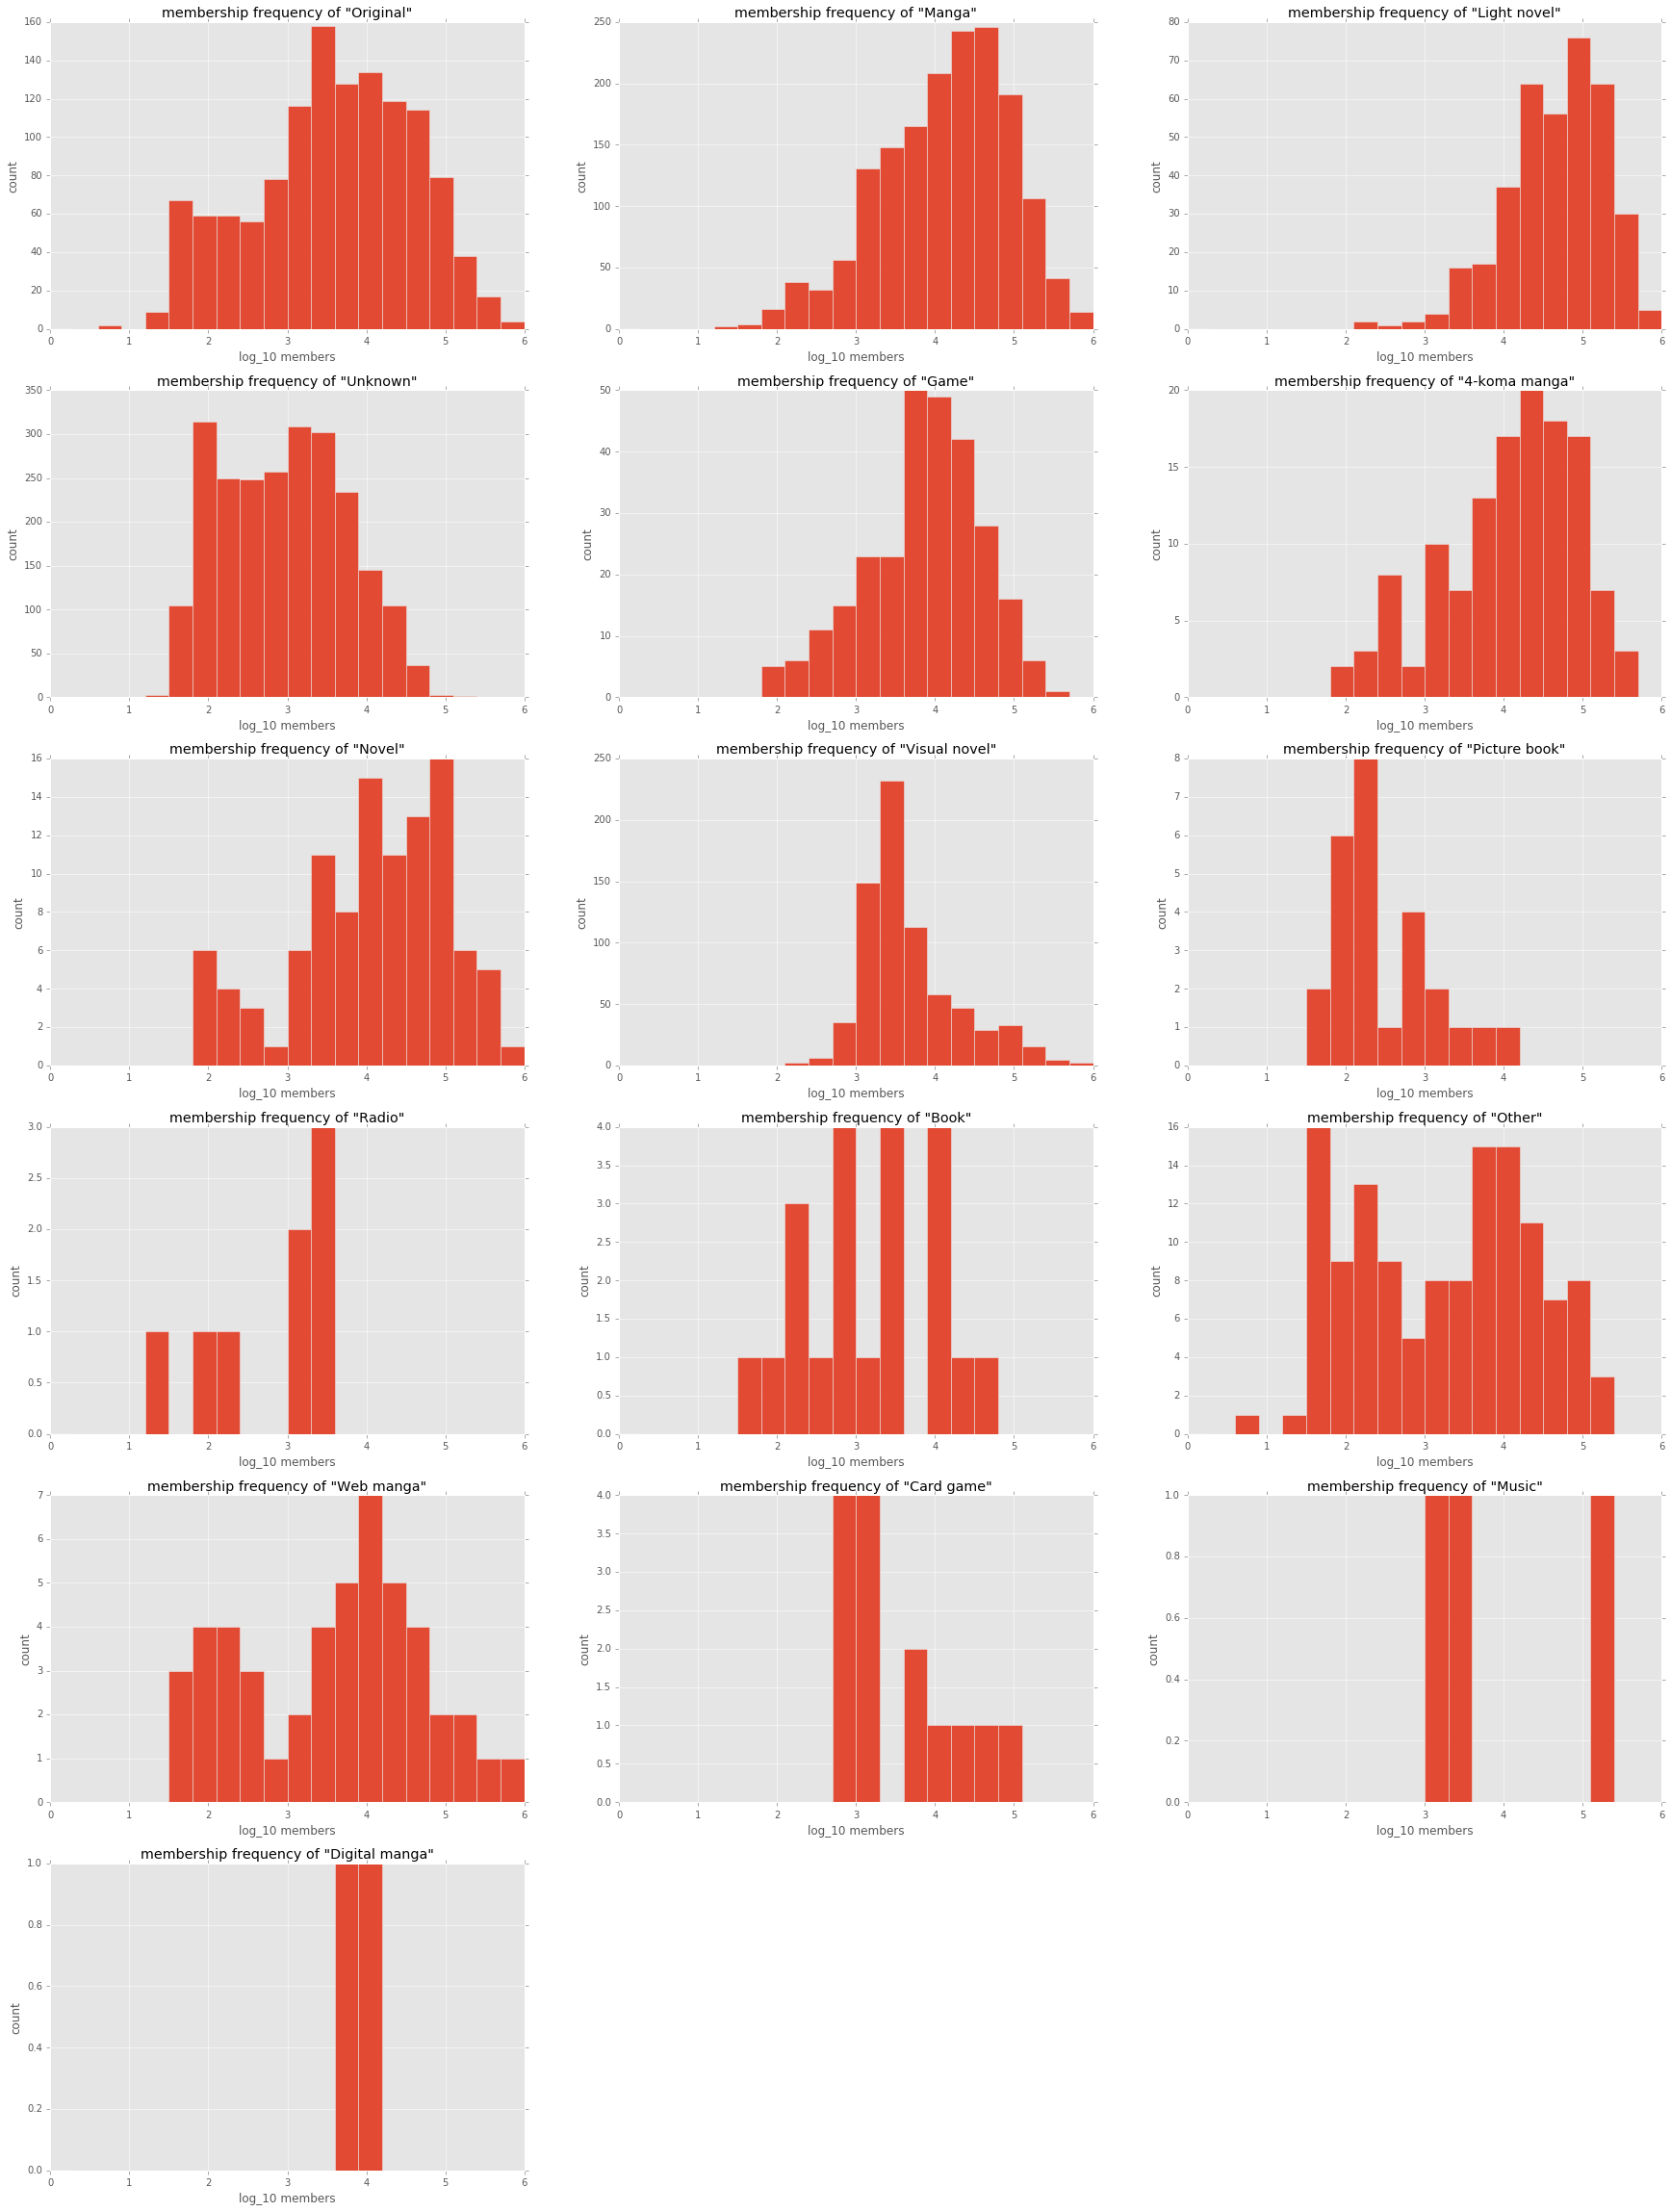

In [20]:
matplotlib.rcParams['figure.figsize'] = (30.0, 40.0)
i = 1
for source in all_sources:
    plt.subplot(6, 3, i)
    plt.hist(np.log10(with_sources[with_sources[source] == 1.0]['members']), bins=20, range=[0.0, 6.0])
    plt.xlabel('log_10 members')
    plt.ylabel('count')
    plt.title('membership frequency of "%s"' % source)
    i += 1

In [21]:
with_sources[with_sources['Digital manga'] == 1]['title']

6615                            Ame-iro Cocoa
6853    Ame-iro Cocoa: Rainy Color e Youkoso!
Name: title, dtype: object

## Learning With Everything

### Define Needed functions

In [22]:
clean_df = MAL_df[MAL_df['hentai'] == 0].copy()

In [17]:
intuitive_thresholds = [
    ('barely_watchable', 6.7),
    ('average', 7.2),
    ('above_average', 7.6),
    ('recommendable', 8.0),
    ('amazing', 8.5),
    ('gods', 9.0)
]

def to_bayes_score(score):
    return ((score - 1.0) / 9.0)

def percentages(df):
    print "Using regular score"
    for label, val in intuitive_thresholds:
        print "{} ({}): {}".format(
            label,
            val,
            1. - float(sum(df['score'] > val)) / df.shape[0])
        
    print ""
    print "Using bayes scores"
    for label, val in intuitive_thresholds:
        thresh = ((val - 1.0) / 9.0)
        print "{} ({}): {}".format(
            label,
            thresh,
            1. - float(sum( df['bayes_score'] > thresh )) / df.shape[0])
        
def percentage_bayes_score(df, score):
    return float(sum( df['bayes_score'] > score )) / df.shape[0]

print "==== Percentiles of Titles ===="
percentages(MAL_df)


==== Percentiles of Titles ====
Using regular score
barely_watchable (6.7): 0.47247446084
average (7.2): 0.694665153235
above_average (7.6): 0.851447219069
recommendable (8.0): 0.935726447219
amazing (8.5): 0.987514188422
gods (9.0): 0.998155505108

Using bayes scores
barely_watchable (0.633333333333): 0.483115777526
average (0.688888888889): 0.700340522134
above_average (0.733333333333): 0.854994324631
recommendable (0.777777777778): 0.937712826334
amazing (0.833333333333): 0.988365493757
gods (0.888888888889): 0.998723041998


Labels are 1 for anything above a score of 7.2, and 0 for anything below. A score of 7.2 represents my personal interpretation of what's "average."

In [19]:
median_bayes_score = np.median(MAL_df['bayes_score'])
print "Median bayes_score:", median_bayes_score
print "Median Score", median_bayes_score * 9 + 1

def split_data_by_date(df):
    df = df.sort_values('aired_start')
    t_date = pd.to_datetime('2012-01-01')
    v_date = pd.to_datetime('2015-01-01')
    train = df[df['aired_start'] < t_date]
    val   = df[(df['aired_start'] >= t_date) & (df['aired_start'] < v_date)]
    test  = df[df['aired_start'] >= v_date]
    return train, val, test

def make_features(df):
    p1 = make_studio_features(df, all_studios)
    p2 = df[all_genre + ['norm_length']]
    p3 = make_source_features(df, all_sources)
    join = pd.concat([p1, p2, p3], axis=1, join='inner')
    return join

def make_labels(df):
#     return df['bayes_score'] > median_bayes_score
    return df['bayes_score'] > to_bayes_score(7.2) #~70 percentile


Median bayes_score: 0.637666403874
Median Score 6.73899763487


### Train, Validation, Test Split

**Use one of the following 3 cells to produce the training/validation/test set.**

In [32]:
# This splits it into the extremes as defined by idx
data = MAL_df
extreme_percentage = percentage_bayes_score(data, to_bayes_score(7.2)) * 100

print "Using only top and bottom {0:.2f}%% of entries to train and test.".format(extreme_percentage)

idx = ((data["bayes_score"] > np.percentile(data["bayes_score"], 100 - extreme_percentage)) |
       (data["bayes_score"] < np.percentile(data["bayes_score"], extreme_percentage))).values


train_df, val_df, test_df = split_data_by_date(data[idx])
print "available", data.shape[0]
print "considered", data[idx].shape[0]
print "train", train_df.shape[0]
print "validation", val_df.shape[0]
print "test", test_df.shape[0]

X_tr, y_tr = make_features(train_df), make_labels(train_df)
X_cv, y_cv = make_features(val_df), make_labels(val_df)

print X_tr.shape
print X_cv.shape

Using only top and bottom 29.97%% of entries to train and test.
available 7048
considered 4224
train 2741
validation 1100
test 383
(2741, 362)
(1100, 362)


In [138]:
# This does a random split of the data into training and cross validation
data = clean_df

np.random.seed(100)
permute = np.random.permutation(data.shape[0])
permute_tr = permute[:train_df.shape[0]]
permute_cv = permute[train_df.shape[0]:train_df.shape[0]+val_df.shape[0]]

print permute_tr.shape
print permute_cv.shape

random_tr = data.iloc[permute_tr]
random_cv = data.iloc[permute_cv]

X_tr, y_tr = make_features(random_tr), make_labels(random_tr)
X_cv, y_cv = make_features(random_cv), make_labels(random_cv)

print X_tr.shape
print X_cv.shape

(2306L,)
(1003L,)
(2306, 362)
(1003, 362)


In [20]:
# This uses everything, not just those in the extremes
data = MAL_df

train_df, val_df, test_df = split_data_by_date(data)
print "available", data.shape[0]
print "train", train_df.shape[0]
print "validation", val_df.shape[0]
print "test", test_df.shape[0]

X_tr, y_tr = make_features(train_df), make_labels(train_df)
X_cv, y_cv = make_features(val_df), make_labels(val_df)
X_test, y_test = make_features(test_df), make_labels(test_df)

print "X_tr", X_tr.shape

available 7048
train 4685
validation 1754
test 609
X_tr (4685, 362)


### Training classifiers

#### Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_tr, y_tr)

score = clf.score(X_cv, y_cv)
print "score", score

score 0.781071835804


#### Logistic Regression

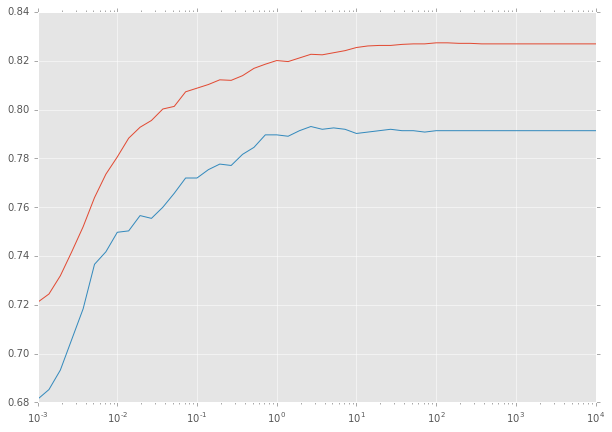

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

def get_err_reg(clf, X, y, X_cv, y_cv, C):
    clf.C = C
    clf.fit(X, y)
    return np.array([clf.score(X, y), clf.score(X_cv, y_cv)])

C = np.logspace(-3, 4, 50)
errors = np.array([get_err_reg(clf, X_tr, y_tr, X_cv, y_cv, c) for c in C])

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
plt.semilogx(C, errors[:,0], C, errors[:,1]);

In [23]:
#clf = LogisticRegression(C=1.8) # Use this when considering all data, not just extremities
# clf = LogisticRegression(C=1.33) # Use this when considering top/bottom 30%
clf = LogisticRegression(C=1.9) # Use this when considering all data for above/below 70 percentile
clf.fit(X_tr, y_tr)
print clf.score(X_tr, y_tr)
print clf.score(X_cv, y_cv)
print clf.score(X_test, y_test)

0.821131270011
0.791334093501
0.8013136289


Which factors impact the prediction most?

In [24]:
feature_names = np.array(X_tr.columns.values)
sorted(zip(feature_names, clf.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:10]

[(u'Pink Pineapple', 2.304494539227008),
 (u'Bridge', 2.3020860756218173),
 (u'PoRO', 2.2367444093417315),
 (u'Khara', 2.1293753603491683),
 (u'TNK', -2.0856304476390157),
 (u'Studio Rikka', 1.9731435744901045),
 (u'White Fox', 1.892637701964313),
 (u'Actas', -1.8768393828095704),
 (u'Kyoto Animation', 1.8136963299324107),
 (u'CoMix Wave Films', 1.786618326965506)]

In [30]:
feature_coeff = pd.DataFrame(sorted(zip(feature_names, clf.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True),
                             columns=['Feature Name', 'Coefficient'])

In [31]:
feature_coeff[feature_coeff['Feature Name'].apply(lambda s: s in all_genre)].head(5)

,Feature Name,Coefficient
17,josei,1.638883
53,mystery,1.117412
57,hentai,-1.099828
64,thriller,1.047067
69,psychological,0.954344


In [45]:
feature_coeff[feature_coeff['Feature Name'].apply(lambda s: s in all_studios)].head(15)

,Feature Name,Coefficient
0,Pink Pineapple,2.304495
1,Bridge,2.302086
2,PoRO,2.236744
3,Khara,2.129375
4,TNK,-2.085630
5,Studio Rikka,1.973144
6,White Fox,1.892638
7,Actas,-1.876839
8,Kyoto Animation,1.813696
9,CoMix Wave Films,1.786618


In [33]:
feature_coeff[feature_coeff['Feature Name'].apply(lambda s: s in all_sources)].head(5)

,Feature Name,Coefficient
38,Radio,-1.267184
58,Card game,-1.090301
61,Light novel,1.082272
98,Unknown,-0.750507
105,Novel,0.696751


### Playing with Predictions

In [35]:
title_to_predict = 'Amagi Brilliant Park'
clf.predict(make_features(clean_df[clean_df['title'] == title_to_predict]))

array([ True], dtype=bool)

### Scoring on Everything

In [36]:
percentages(MAL_df)

Using regular score
barely_watchable (6.7): 0.47247446084
average (7.2): 0.694665153235
above_average (7.6): 0.851447219069
recommendable (8.0): 0.935726447219
amazing (8.5): 0.987514188422
gods (9.0): 0.998155505108

Using bayes scores
barely_watchable (0.633333333333): 0.483115777526
average (0.688888888889): 0.700340522134
above_average (0.733333333333): 0.854994324631
recommendable (0.777777777778): 0.937712826334
amazing (0.833333333333): 0.988365493757
gods (0.888888888889): 0.998723041998


In [57]:
# This uses everything, not just those in the extremes
data = MAL_df

train_df, val_df, test_df = split_data_by_date(data)
print "available", data.shape[0]
print "train", train_df.shape[0]
print "validation", val_df.shape[0]
print "test", test_df.shape[0]

X_tr, y_tr = make_features(train_df), make_labels(train_df)
X_cv, y_cv = make_features(val_df), make_labels(val_df)
X_test, y_test = make_features(test_df), make_labels(test_df)

print "X_tr", X_tr.shape

available 7048
train 4685
validation 1754
test 609
X_tr (4685, 362)


In [58]:
# Use the entire test set (in case we used only extremities earlier)
clf.score(X_test, y_test)

0.80131362889983582

In [59]:
# Score on all data
clf.score(make_features(MAL_df), make_labels(MAL_df))

0.8120034052213394

In [60]:
# Accuracy on positives
pos_idx = y_test > 0
print "Positive accuracy", clf.score(X_test[pos_idx], y_test[pos_idx])

neg_idx = y_test < 1
print "Negative accuracy", clf.score(X_test[neg_idx], y_test[neg_idx])

Positive accuracy 0.605405405405
Negative accuracy 0.88679245283


### Graphing the Data

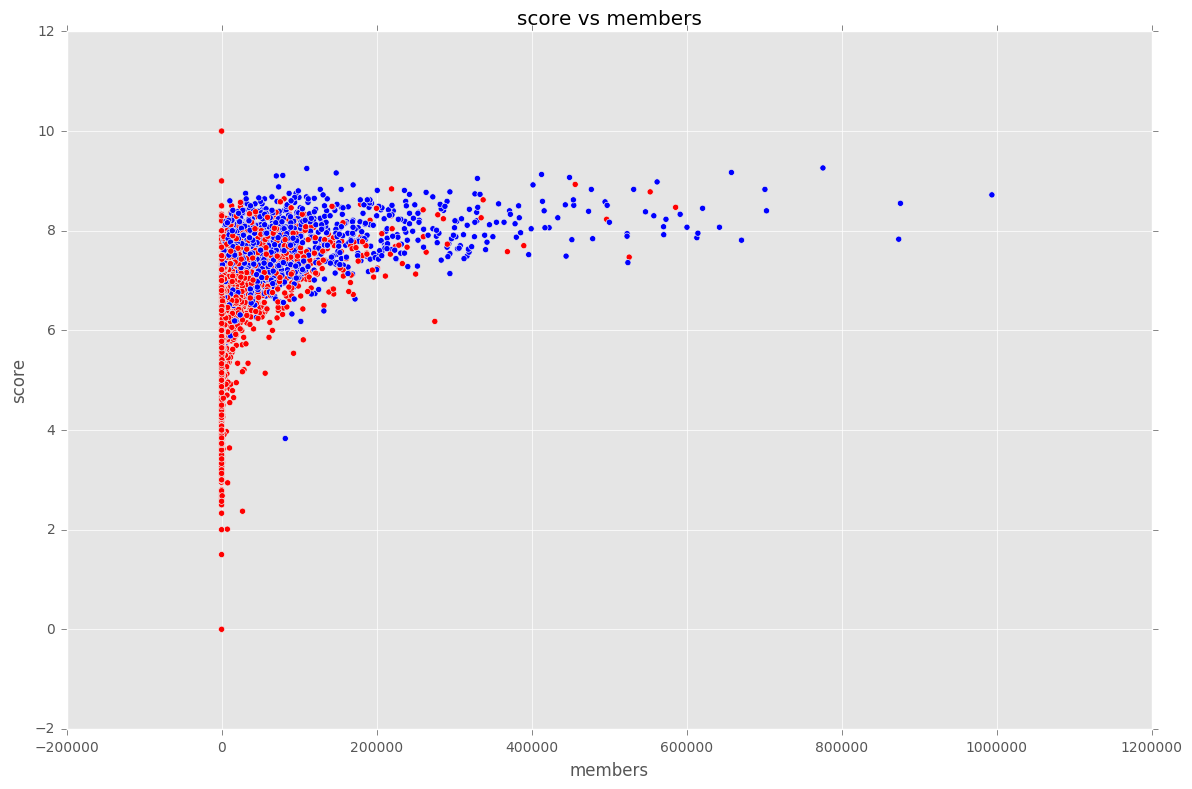

In [61]:
colors = np.array([
            [1, 0, 0],
            [0, 0, 1],
            [0, 0, 0]
        ])

classes = pd.Series(clf.predict(make_features(MAL_df)).astype(int))
#classes[MAL_df['hentai'] == 1] = 2
colored_classes = colors[classes]

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['score'], c=colored_classes)
plt.xlabel("members")
plt.ylabel("score")
plt.title('score vs members')
plt.show()

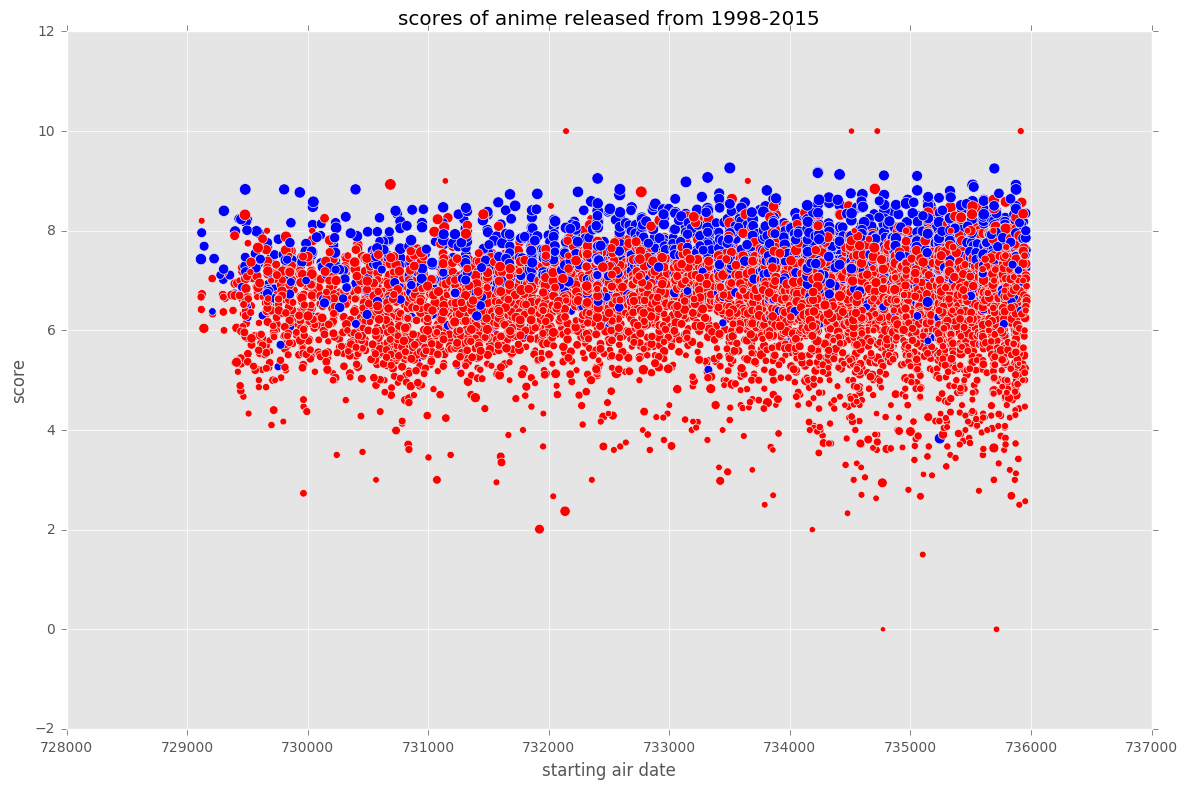

In [69]:
newer_shows = MAL_df[MAL_df['aired_start'] > pd.to_datetime('1997')]

colors = np.array([
            [1, 0, 0],
            [0, 0, 1],
            [.8, .8, .8]
        ])

classes = pd.Series(clf.predict(make_features(newer_shows)).astype(int))
#classes[MAL_df['hentai'] == 1] = 2
colored_classes = colors[classes]

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)

sizes = (np.log(newer_shows['members']) + 1) * 5

x_axis = newer_shows['aired_start'].apply(matplotlib.dates.date2num)
plt.scatter(x_axis, newer_shows['score'], c=colored_classes, s=sizes)
#plt.plot_date(x_axis, newer_shows['bayes_score'], marker='o', c=colored_classes, s=sizes)
plt.xlabel("starting air date")
plt.ylabel("score")
plt.title('scores of anime released from 1998-2015')
plt.show()

## DO NOT USE THE FOLLOWING SECTION

In [265]:
hentai = MAL_df[MAL_df['hentai'] == 1]
len(hentai)

923

In [266]:
print MAL_df['yaoi'].sum()
print MAL_df['yuri'].sum()

27
29


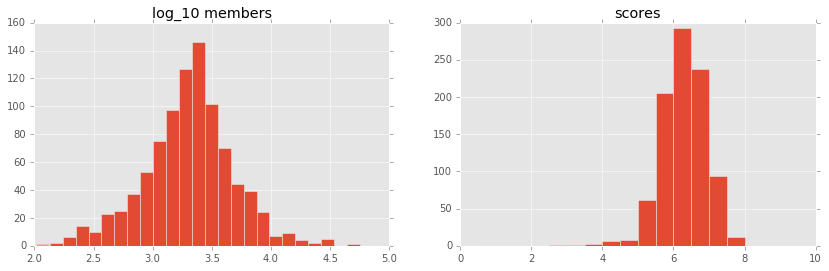

In [272]:
matplotlib.rcParams['figure.figsize'] = (14.0, 4.0)

plt.subplot(1,2,1)
plt.hist(np.log10(hentai['members']), bins=25)
plt.title('log_10 members')
plt.subplot(1,2,2)
plt.hist(hentai['score'], bins=20, range=[0.0, 10.0])
plt.title('scores');


In [81]:
hentai[['title', 'score', 'members', 'studios']].sort_values(['score', 'members'], ascending=False)

,title,score,members,studios
0,Oni Chichi: Re-born,7.90,14058,[u'PoRO']
0,Mankitsu Happening,7.83,8070,[]
0,Oni Chichi: Rebuild,7.76,9577,[u'PoRO']
0,Koiito Kinenbi The Animation,7.75,6835,[]
0,Eroge! H mo Game mo Kaihatsu Zanmai,7.68,19888,[u'Collaboration Works']
0,Oni Chichi: Re-birth,7.65,14630,[u'PoRO']
0,Rance 01: Hikari wo Motomete The Animation,7.59,5879,[u'Seven']
0,Swing Out Sisters (2014),7.59,4986,[]
0,Maki-chan to Nau.,7.57,9371,[u'Collaboration Works']
0,Stringendo: Angel-tachi no Private Lesson,7.55,7593,[u'Flavors Soft']


In [72]:
hentai[all_genre].apply(lambda r: sum(r) == 1, axis=1).sum()

706

In [70]:
hentai[all_genre].sum(axis=0).sort_values(ascending=False)

hentai                            923
supernatural                       48
school                             45
fantasy                            44
demons                             33
harem                              29
romance                            24
comedy                             23
yuri                               22
action                             21
horror                             17
drama                              15
magic                              14
sci-fi                             14
adventure                          10
yaoi                                7
martial arts                        7
historical                          5
super power                         4
psychological                       4
military                            3
sports                              3
mystery                             3
police                              3
mecha                               2
space                               2
music       